# APARTAT A: CLASSIFICACIÓ

Per a aquest apartat (A), es calcularà els errors en classiﬁcació (precisió) comés per dos models, el regressor logístic i la màquina de vectors de suport (amb diferents kernels, linear, polinomial, gaussià). Esprovarandiferentsparàmetrespelskernelspertrobarlaconﬁguraciódelclassiﬁcador que dona millors resultats

### Així es podrà contestar a aquestes preguntes:
1. Com inﬂueix l’avaluació dels experiments en la interpretació dels resultats? Quin creieu que és el més ﬁable, LOOCV o K-fold? 
2. Quin és el millor model de classiﬁcació, en termes de f1-measure, i en el cas dels SVM amb quin kernel i quins paràmetres C i gamma? 
3. Quina informació complementària dóna cada una de les mesures de rendiment implementades? és a dir, quina és la mesura més complerta (corba ROC o corba Precision-Revall) i quin signiﬁcat té en el vostre problema? 
4. Com de diferent és la conﬁguració ﬁnal del classiﬁcador tenint en compte aquestes noves mesures respecte al millor model que heu trobat utilitzant únicament la precisió? 
5. Quina informació addicional us dóna la visualització del classiﬁcador en 3D en el vostre problema? us permet deduir quin seria el kernel del SVM que aniria millor, o us permet identiﬁcar outliers?


In [115]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd

from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)


### LLEGIM LA BASE DE DADES DEL CSV

In [116]:
# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

dataset = load_dataset("ds/mushrooms.csv")
print(dataset.columns)

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')


__Escollim com a atribut objectiu la classificació__, que pot tenir dos valors: poisonous (verinós) i edible (comestible)

In [117]:
target = 'class'

Com podem veure a la gràfica seguent, class és un bon paràmetre ja que té les dades prou balancejades

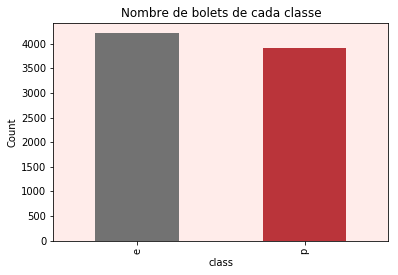

In [118]:
plt.figure()
pd.Series(dataset['class']).value_counts().sort_index().plot(kind = 'bar', color=["#727272", "#ba343a"])
ax = plt.gca()
ax.set_facecolor('#ffecea')
plt.ylabel("Count")
plt.xlabel("class")
plt.title('Nombre de bolets de cada classe');

Com sabem per la informació de la base de dades, els valors desconeguts es mostren dins de la base de dades com a ?, per tant els transformem primer a NaN per tractar-los

In [119]:
import numpy as np
dataset = dataset.replace({'?':np.NaN})
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  5644 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

Podem observar que totes les variables estan completes excepte l'atribut __stalk-root__. Havent-hi pràcticament la meitat de valors desconeguts, optem per descartar completament aquesta variable d'entrada.

In [120]:
del dataset["stalk-root"]

#la variable veil-type només conté un únic valor, per tant també l'eliminem.
del dataset["veil-type"]

In [121]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 21 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-color                  8124 non-null object
ring-number                 8124 non-null object
ring-type                   8124 non-null object
spore-print

plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

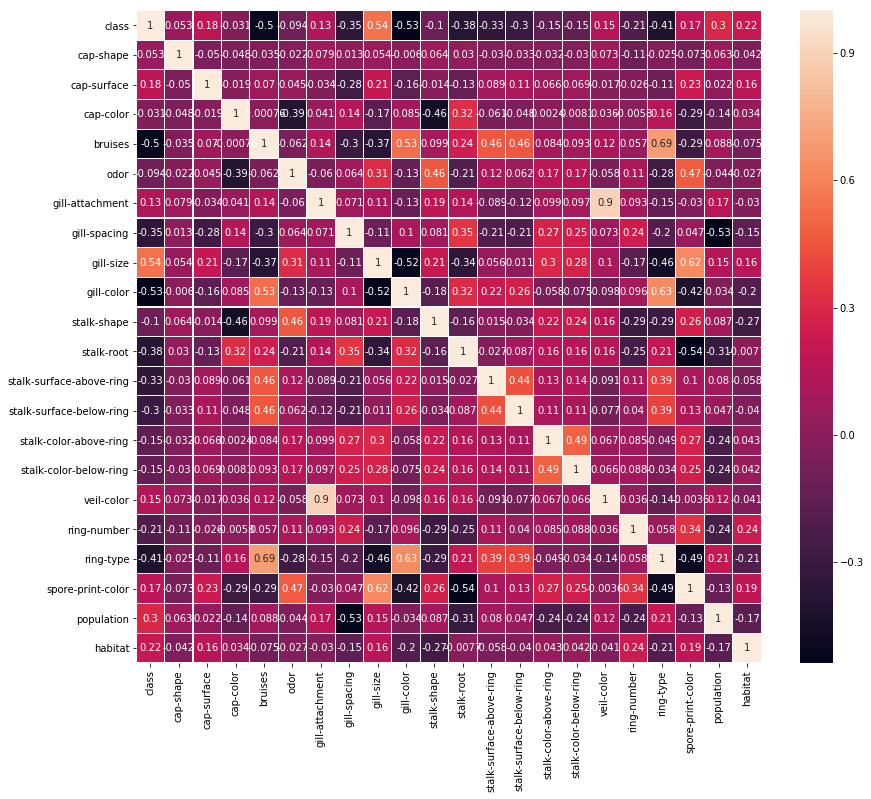

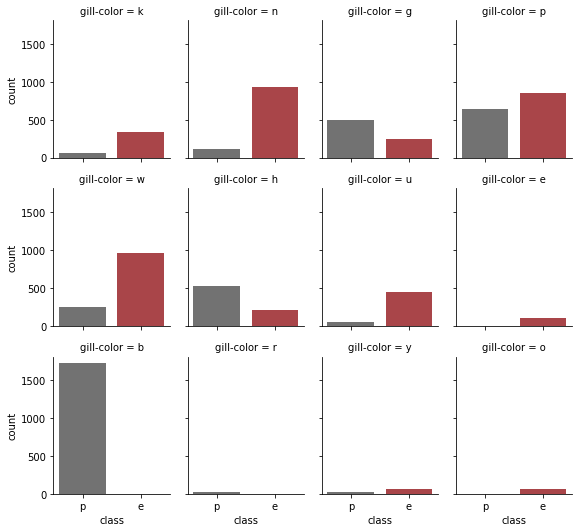

In [122]:
new_var= round(dataset[['class', 'gill-color']], 3)
sb.catplot('class', col='gill-color', data=new_var, kind='count', height=2.5, aspect=.8, col_wrap=4, palette = sb.color_palette(palette = ["#727272", "#ba343a"], n_colors = 2));

Per poder tractar les dades, passem les variables, totes categòriques, a numèriques, entre 0 i 1. D'aquesta manera ens estalviem fer la normalització.

In [69]:
dataset["class"] = [1 if i == "p" else 0 for i in dataset["class"]]
for column in dataset.drop(["class"], axis=1).columns:
    value = 0
    step = 1/(len(dataset[column].unique())-1)
    for i in dataset[column].unique():
        dataset[column] = [value if letter == i else letter for letter in dataset[column]]
        value += step
        
#mostrem el principi i el final de les taules
data_check = dataset.head()
data_check = data_check.append(dataset.tail())
data_check

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0,0.000,0.000,0.111,0.000,0.125,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.125,0.200,0.167
2,0,0.200,0.000,0.222,0.000,0.250,0.000,0.000,1.000,0.091,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.125,0.200,0.333
3,1,0.000,0.333,0.222,0.000,0.000,0.000,0.000,0.000,0.091,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0,0.000,0.000,0.333,1.000,0.375,0.000,1.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.250,0.125,0.400,0.167
8119,0,0.800,0.000,0.000,1.000,0.375,1.000,0.000,1.000,0.909,...,0.000,0.000,0.750,0.875,0.667,0.000,0.000,1.000,1.000,1.000
8120,0,0.000,0.000,0.000,1.000,0.375,1.000,0.000,1.000,0.909,...,0.000,0.000,0.750,0.875,0.333,0.000,0.000,1.000,0.600,1.000
8121,0,0.600,0.000,0.000,1.000,0.375,1.000,0.000,1.000,0.091,...,0.000,0.000,0.750,0.875,0.667,0.000,0.000,1.000,1.000,1.000
8122,1,0.800,0.333,0.000,1.000,0.750,0.000,0.000,0.000,0.727,...,0.000,1.000,0.000,0.000,0.000,0.000,0.250,0.500,0.600,1.000
8123,0,0.000,0.000,0.000,1.000,0.375,1.000,0.000,1.000,0.909,...,0.000,0.000,0.750,0.875,0.667,0.000,0.000,0.750,1.000,1.000


In [70]:
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

y = dataset["class"].values
x = dataset.drop(["class"], axis=1).values

Correct classification Logistic  0.5 %:  0.9766125061546036
Correct classification Logistic  0.5 %:  0.9766125 

Correct classification Logistic  0.7 %:  0.9762100082034455
Correct classification Logistic  0.7 %:  0.97621 

Correct classification Logistic  0.8 %:  0.9790769230769231
Correct classification Logistic  0.8 %:  0.9790769 



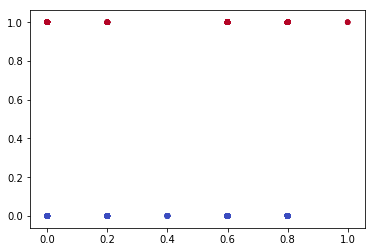

In [113]:
#x = np.random.random((100, 3))
#y = np.array([-1, 1])[np.random.randint(0, 2, 100)]
plt.figure()
ax = plt.scatter(x[:, 0], y, c=y, cmap=plt.cm.coolwarm, s=20) #, edgecolors='k')
particions = [0.5, 0.7, 0.8]

for part in particions:
    x_t, y_t, x_v, y_v = split_data(x, y, part)

    # Creem el regresor logístic
    logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001)  
    # l'entrenem
    logireg.fit(x_t, y_t)
    print("Correct classification Logistic ", part, "%: ", logireg.score(x_v, y_v))

    y_pred = logireg.predict(x_v)
    percent_correct_log = np.mean(y_v == y_pred).astype('float32')
    print("Correct classification Logistic ", part, "%: ", percent_correct_log, "\n")

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

#Creem el regresor logístic
logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001)

#Creem la partició K-fold, K=5 i apliquem el regressor logístic
scores = cross_val_score(logireg, x, y, cv=10)

# mirem el resultat
score = scores.mean()
y_pred = cross_val_predict(logireg, x, y, cv=10) 
print("Accuracy Kfold:",score)

Accuracy Kfold: 0.9162705909462987


In [79]:
#Creem la partició LOOCV, i apliquem el regressor logístic
loo = LeaveOneOut()

scores=[]
for train_index, test_index in loo.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    logireg.fit(X_train,y_train)
    scores.append(logireg.score(X_test,y_test))
    

# mirem el resultat
score = np.mean(scores)
y_pred = logireg.predict(x) 
print("Accuracy LOOCV",score)  

Accuracy LOOCV 0.9790743476120138


In [87]:
# SVM
def train_svm(x, y, kernel='linear', C=0.01, gamma=0.001, probability=True): 
    if(kernel =='linear'):
        svclin = svm.SVC(C=C, kernel=kernel, gamma=gamma, probability=probability) 
    if(kernel =='poly'):
        svclin = svm.SVC(C=C, kernel=kernel, gamma=gamma, probability=probability) 
    if(kernel =='rbf'):
        svclin = svm.SVC(C=C, kernel=kernel, gamma=gamma, probability=probability) 

    # l'entrenem
    svclin.fit(x, y)
    
    return svclin.score(x,y)
print("Accuracy SVM: ", train_svm(x,y))

Accuracy SVM:  0.9374692269817824


## Es recomana fer una taula amb el mètode, paràmetres i precisió obtinguda.

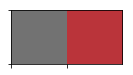

In [96]:
sb.palplot(sb.color_palette(palette = ["#727272", "#ba343a"], n_colors = 2))